In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from showlib import * 

## CH3 強度轉換與空間濾波(Intensity Transformationa and Spatial Filtering)

空間域（spatial domain）轉換是相對於頻率域（frequency domain）進行的轉換。它直接作用於二維影像的像素。一般來說，此類運算更高效，所需資源也較少。

空間域轉換之目的很多，增強對比度(contrast enhancement)、濾除雜訊是其中之大課題。空間域轉換之手段可以透過強度轉換函數、空間濾波器等等。
常見之關鍵字:
強度轉換函數、空間濾波器、核、對比度擴展、直方圖等化

### CH3-1 基本強度轉換函數(Intensity Transformation Functions)
強度轉換函數之定義如下，其中$f(x,y)$為輸入之函數，$g(x,y)$為輸出函數，$T$則為連接兩者之轉移函數。此轉轉移函數用以實現圖片之強度之映射。此種方式用來實現影像處理之優點是簡單好用，但效果有限，畢竟是整體一起調整，對於圖片中相同像素強度但處於不同位置之像素處理方式會是相同的，無法起到影像分隔或是針對某特定範圍進行針對性處裡的效果。
$$g(x,y)=T[f(x,y)]$$

常見之轉換函數如下(橫軸為強度輸入準位，縱軸為強度輸出準位)

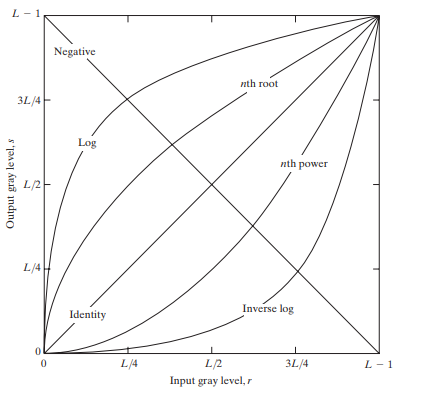



"恆等轉換(Identity Transformation)"，定義為$s = r$。<br />
"影像負片(Negative Transformation)"，定義為$s = L - 1 - r$。<br />
"Log 轉換(Log Transformation)"，定義為$s = c \log(1+r) $，c為常數，$r \ge 0$。(大量壓縮動態範圍，適合用在fft頻域圖大動態範圍之用)<br />
"乘冪率轉換(Gamma Transformation)"，定義為$s = c r^{\gamma} $，c，$\gamma$ 為正常數。$\gamma$各種值如下圖，$\gamma$與c為1時，為恆等轉換。<br />
"逐段線性轉換函數(PIECEWISE LINEAR TRANSFORMATION FUNCTIONS)"，使用分段函數進行定義。


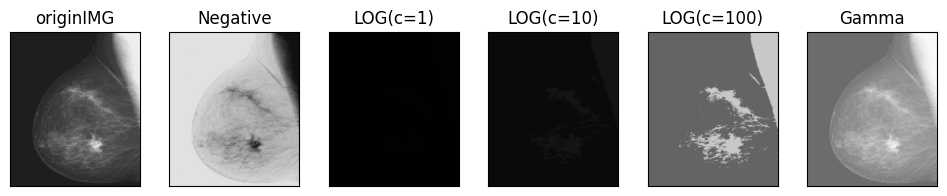

In [2]:
originIMG = cv2.imread('source_img/breast_digital_Xray.tif')
RGBIMG =  cv2.cvtColor(originIMG,cv2.COLOR_BGR2RGB)#cv2 read img in BGR, PLT shows in RGB
####->openCV 讀進來是uint ---> 沒有負，Negative Transformation其實可以直接 -RGBIMG 得到，但在這裡，先換成int更general。
RGBIMG=RGBIMG.astype('int')


Negative=255-RGBIMG#Negative Transformation
LogC1=1*np.log10(1+RGBIMG).astype('int')
LogC10=10*np.log10(1+RGBIMG).astype('int')
LogC100=100*np.log10(1+RGBIMG).astype('int')
Gamma=((((RGBIMG/255).astype('float'))**0.4)*255).astype('int');#輸入0~1
print()
show6plt(RGBIMG,Negative,LogC1,LogC10,LogC100,Gamma,n1="originIMG",n2="Negative",n3="LOG(c=1)",n4="LOG(c=10)",n5="LOG(c=100)",n6="Gamma")


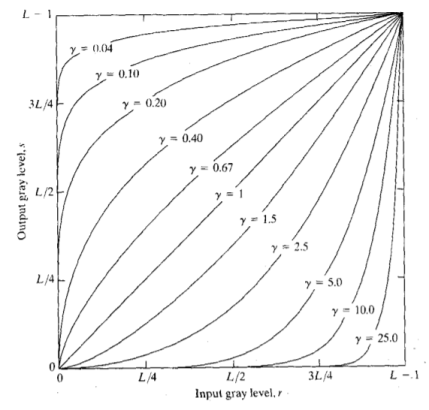

配合不同的gamma值可以達到不同的效果，一般來說gamma越小越有漂白的效果，小範圍的暗色部分被映射到較大的區域，而大部分中色調與亮部都被往亮部推，理論上暗部的解析準位對比變高。
越大會有增色變暗的效果，同樣的因為中色調被往暗處推，亮色調被映射到原本亮色與中色調的位置，範圍變大，理論上原本屬於亮部部分之對比度會提升。

gamma校正也被應用在色彩校正上，也就是拉曲線。

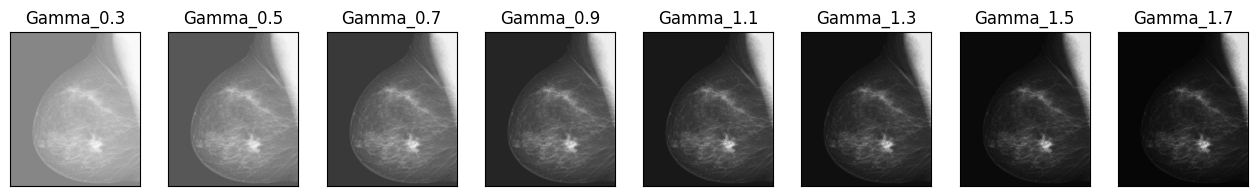

In [3]:
Gamma_03=((((RGBIMG/255).astype('float'))**0.3)*255).astype('int');
Gamma_05=((((RGBIMG/255).astype('float'))**0.5)*255).astype('int');
Gamma_07=((((RGBIMG/255).astype('float'))**0.7)*255).astype('int');
Gamma_09=((((RGBIMG/255).astype('float'))**0.9)*255).astype('int');
Gamma_11=((((RGBIMG/255).astype('float'))**1.1)*255).astype('int');
Gamma_13=((((RGBIMG/255).astype('float'))**1.3)*255).astype('int');
Gamma_15=((((RGBIMG/255).astype('float'))**1.5)*255).astype('int');
Gamma_17=((((RGBIMG/255).astype('float'))**1.7)*255).astype('int');

show8plt(Gamma_03,Gamma_05,Gamma_07,Gamma_09,Gamma_11,Gamma_13,Gamma_15,Gamma_17,
         n1="Gamma_0.3",n2="Gamma_0.5",n3="Gamma_0.7",n4="Gamma_0.9",n5="Gamma_1.1",n6="Gamma_1.3",n7="Gamma_1.5",n8="Gamma_1.7")

"對比度擴展(contract stretching)" 將輸入準位的某段小範圍映射到輸出準位的較大範圍，如下PL4。<br/>
"強度準位切片(Intensity-Level Slicing)" 如果對某一輸入準位有興趣，可以將他映射到輸出準位到一高對比位置，類似highlight作用。兩種常見方法是將感興趣的部分升至最高，其他則保持不變如下PL2。另一種則時將其他變成0，輸出為二值化影像，如下PL1。<br/>
位元平面切片(Bit-Plane Slicing) 是將圖片中某位元準位進行的切面，是強度準位切面的特例。可以用來看某一位元對整體圖片之貢獻分布。


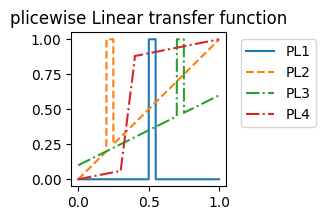

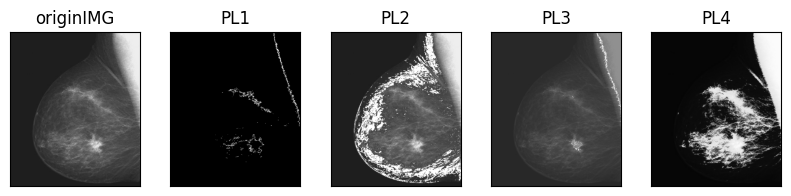

In [4]:
def Piecewise_linear1(input):
    return np.where((input > 0.5) & (input < 0.55), 1, 0)
def Piecewise_linear2(input):
    return np.where((input > 0.2) & (input < 0.25), 1, input)
def Piecewise_linear3(input):
    return np.where((input > 0.7) & (input < 0.75), 1, 0.5*input+0.1)
def Piecewise_linear4(input):
    return np.where((input > 0.3), 
                    np.where((input > 0.4), 0.2*input+0.8, 8*input-2.35), 
                    0.2*input)

plt.figure(figsize=(2,2))
x=np.arange(0,1,0.001);
plt.plot(x,Piecewise_linear1(x),label='PL1',linestyle='-');
plt.plot(x,Piecewise_linear2(x),label='PL2',linestyle='--');
plt.plot(x,Piecewise_linear3(x),label='PL3',linestyle='-.');
plt.plot(x,Piecewise_linear4(x),label='PL4',linestyle='-.');

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left');
plt.title("plicewise Linear transfer function")
plt.show()

PL1 = (Piecewise_linear1(((RGBIMG / 255).astype('float'))) * 255).astype('int')
PL2 = (Piecewise_linear2(((RGBIMG / 255).astype('float'))) * 255).astype('int')
PL3 = (Piecewise_linear3(((RGBIMG / 255).astype('float'))) * 255).astype('int')
PL4 = (Piecewise_linear4(((RGBIMG / 255).astype('float'))) * 255).astype('int')

show5plt(RGBIMG,PL1,PL2,PL3,PL4,n1="originIMG",n2="PL1",n3="PL2",n4="PL3",n5="PL4")



### CH3-2 直方圖處理(Histogram processing)
強度準位在$[0,L-1]$中的影像直方圖為一離散函數。定義為$h(r_k)=n_k$，其中$r_k$為第k個強度值，$n_k$為第k個強度之像素個數。正規化的直方圖會在將統計到的像素個數除以整張圖片的像素總量，也就是長乘寬$(NM)$，定義為$p(r_k)=n_k/NM$，此時可以看做是強度準位$r_k$之發生機率。<br />

一般來說，可以發現對比度較低的影像其直方圖之資料傾向於集中在一起，而高對比影像之直方圖則較為平均分佈。因此操作直方圖達成對比度改變之方式可以透過"直方圖等化"與"直方圖匹配"等方式，透過重新調整強度準位機率分布達成對比度的變化。此種方式可以用來增加全局對比度，但若不加以篩選資料也可能造成雜訊對比上升，或是希望測得信號對比下降。操作如下圖(https://spie.org/samples/PM197.pdf)

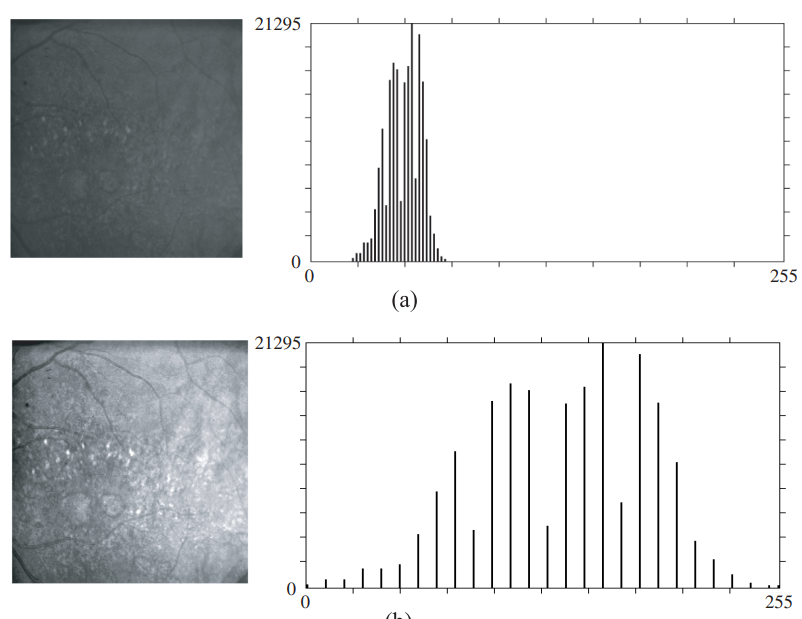


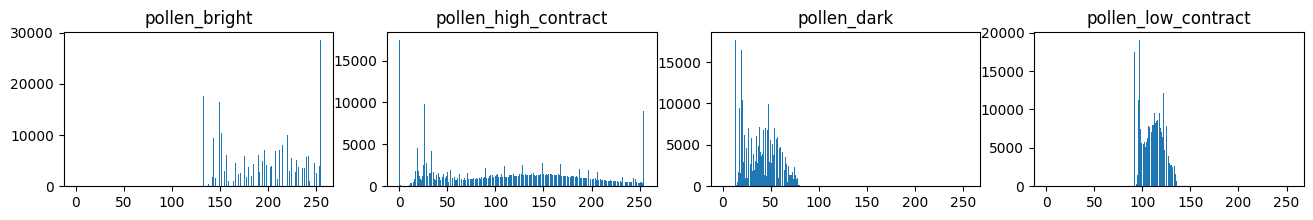

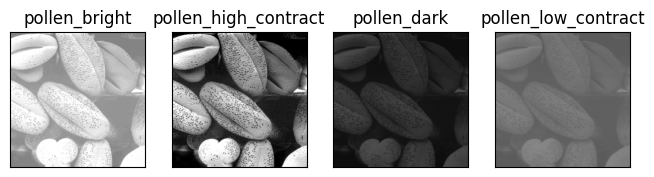

In [5]:
pollen_bright = cv2.imread('source_img/pollen_bright.tif')
pollen_bright =  cv2.cvtColor(pollen_bright,cv2.COLOR_BGR2RGB)

pollen_high_contract = cv2.imread('source_img/pollen_high_contract.tif')
pollen_high_contract  =  cv2.cvtColor(pollen_high_contract,cv2.COLOR_BGR2RGB)

pollen_dark = cv2.imread('source_img/pollen_dark.tif')
pollen_dark  =  cv2.cvtColor(pollen_dark,cv2.COLOR_BGR2RGB)

pollen_low_contract = cv2.imread('source_img/pollen_low_contract.tif')
pollen_low_contract  =  cv2.cvtColor(pollen_low_contract,cv2.COLOR_BGR2RGB)

histogram1, bin_edges1 = np.histogram(cv2.cvtColor(pollen_bright.astype('float32'),cv2.COLOR_RGB2GRAY), bins=np.arange(0,256,1))
histogram2, bin_edges2 = np.histogram(cv2.cvtColor(pollen_high_contract.astype('float32'),cv2.COLOR_RGB2GRAY), bins=np.arange(0,256,1))
histogram3, bin_edges3 = np.histogram(cv2.cvtColor(pollen_dark.astype('float32'),cv2.COLOR_RGB2GRAY), bins=np.arange(0,256,1))
histogram4, bin_edges4 = np.histogram(cv2.cvtColor(pollen_low_contract.astype('float32'),cv2.COLOR_RGB2GRAY), bins=np.arange(0,256,1))

fig =plt.figure(figsize=(16,2));
ax=fig.add_subplot(141)
ax.set_title("pollen_bright")
#ax.set_xlabel("grayscale scale")
#ax.set_ylabel("pixel count")
_ =ax.hist(bin_edges1[:-1], bin_edges1, weights=histogram1)

ax=fig.add_subplot(142)
ax.set_title("pollen_high_contract")
_ =ax.hist(bin_edges2[:-1], bin_edges2, weights=histogram2)

ax=fig.add_subplot(143)
ax.set_title("pollen_dark")
_ =ax.hist(bin_edges3[:-1], bin_edges3, weights=histogram3)

ax=fig.add_subplot(144)
ax.set_title("pollen_low_contract")
_ =ax.hist(bin_edges4[:-1], bin_edges4, weights=histogram4)

show4plt(pollen_bright,pollen_high_contract,pollen_dark,pollen_low_contract,
         n1="pollen_bright",n2="pollen_high_contract",n3="pollen_dark",n4="pollen_low_contract")

#### 直方圖等化數學(連續)

直方圖等化之核心概念是找出一種轉移方式，可以使得直方圖分布可以從集中一區域轉化為均勻分散。<br />
(**以下使用連續說明，只說明了確實有方法有函數可以使其均勻分散，實際的離散implementation後面說明**)。<br />
數學可以基本以以下幾部分概括:<br />
1.假設轉移函數為單調遞增函數，一個連續機率密度函數PDF(先玩會連續的在推廣離散)<br />
2.轉移後之機率函數為轉移前機率函數乘以轉移函數斜率<br />
3.令一個轉移函數，積分後得到轉移後強度變數為轉移前機率函數積分乘以(轉移前強度上限)<br />
4.整理前幾步驟後可以發現經由某種轉換後(這個轉換與輸入的機率分布有關，確實可以得到一個均勻分布的輸出)<br />

1.若將處理之前的影像強度以r表示，處理後已s表示。強度映射使用以下轉換方式:<br />
$$s=T(r) 0\le r\le L-1$$
並且T(r)在此區間內嚴格單調遞增(確保轉過去轉回來都是一對一，方便推導)，(嚴格的意思是後面一定比前面大$<$，若沒有嚴格則後面可以跟前面一樣大$\le$)。並且輸入輸出皆介於0到L-1之間。如下圖https://dl.icdst.org/pdfs/files4/01c56e081202b62bd7d3b4f8545775fb.pdf  p.135<br />
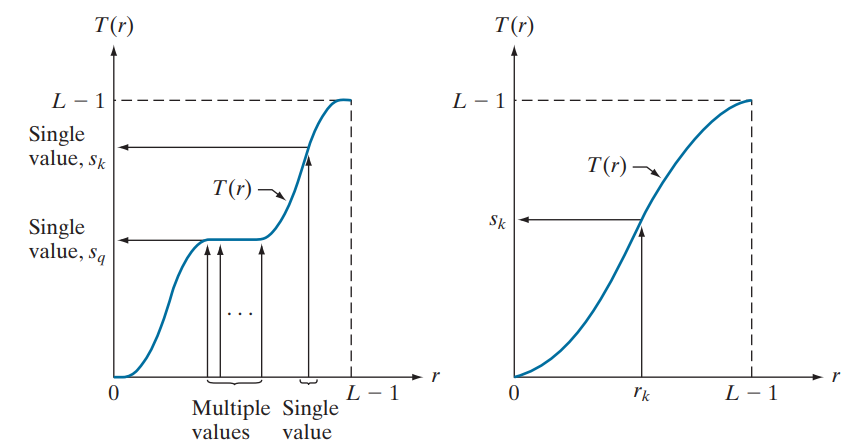<br />
2.來自機率論的結論:映射後的機率密度可由映射前的機率密度<br />
$$p_{s}(s)=p_{r}(r) \left\lvert \frac{dr}{ds} \right\rvert$$
3.在這裡作者選擇了一個轉換函數關係式(這是一個special case，S與轉移函數是用定義的，希望這個轉移函數可以達到使r映射到s後機率分布均勻化的效果)，並且有滿足嚴格遞增與上限(L-1)兩點，我們要證明這個轉換可以用(先寫答案再來證明xd)。這條是說積分到某任意點r，也就是原本輸入的PDF從零到某點底下的面積<br />
$$s=T(r)=(L-1)\int_0^r{p_r(w)dw} $$
我們想要求得的是轉換過後的機率分布$p_s(s)$，微分剛剛的轉換關係後根據Leibnize法則得知，對一個定積分之上限微分就是此被積分式在該極限的值可解得<br />
$$\frac{ds}{dr}=\frac{dT(r)}{dr}=(L-1) \frac{d}{dr}\left[ \int_0^r{p_r(w)dw}\right]=(L-1)p_r(r) $$
4.最後組合(3)與(2)的結果，可以得知確實輸出之$p_s(s)$為一個均勻機率密度函數PDF，也就是說確實可以有一個轉換如(3)所設定的，可以使輸入分布其變均勻。並且此轉換形式$T(r)$與$p_r(r)$相關。這裡的結果顯示了無論輸入的$p_r(r)$如何，所輸出之$p_s(s)$永遠為$\frac{1}{L-1}$(均勻分佈)，可以看上面(1)的圖。

$$p_s(s)=p_r(r)\left\lvert \frac{dr}{ds} \right\rvert=p_r(r)\left\lvert \frac{1}{(L-1)p_r(r)} \right\rvert=\frac{1}{L-1}$$

#### 直方圖等化(離散，實際操作)
根據前一段說明的連續情況，可以知道若要使的輸出PDF達到均勻分佈的效果，可以帶入上一段(3)定義的公式中。當然這裡使用離散，將積分變成sigma，因此輸出的函數肯定只能是"盡量"均勻分布，看直方圖還是會有點高高低低。當然取樣點夠多，可以使每個強度準位之機率更加接近，但無法如連續一樣全部都是$\frac{1}{L-1}$。<br />
首先先使用下式將強度累計轉化為強度機率分佈。<Br />
$$p_r(r_k)=\frac{n_k}{MN} k=0,1,2,...,L-1$$
將上一節之(3)式改寫為<br />
$$s_k=T(r_k)=(L-1)\sum_{j=0}^{k}{p_r(r_j)}=\frac{L-1}{MN}\sum_{j=0}^{k}{n_j}$$ 
其中可以發現$\frac{L-1}{MN}$為定值，需要特別操作的為$\sum_{j=0}^{k}{n_j}$，這其實是機率到這一項之累計，也就是說若想要計算第10個強度準位之映射過去的機率，需要使用前十項累加之機率來計算，為了方便計算，我們會可以定義一個累積分布函數(cumulative distribution function，CDF)。這個是PDF一路累積的結果。乘以$(L-1)$便可得到$T(r)$，利用T(r)，我們可以找到輸入對應的輸出，將每個準位的輸出值四捨五入後可以知道員輸入函數的某一準位會整根搬去哪裡(輸入輸出之直方圖是整根變化的，同一強度準位會一起搬家到別的強度準位，不會只搬一半)。輸出之直方圖高度就看輸入直方圖每根搬去哪裡，然後將搬去相同地方的加一家變成新的機率分布。下圖為說明。<br />
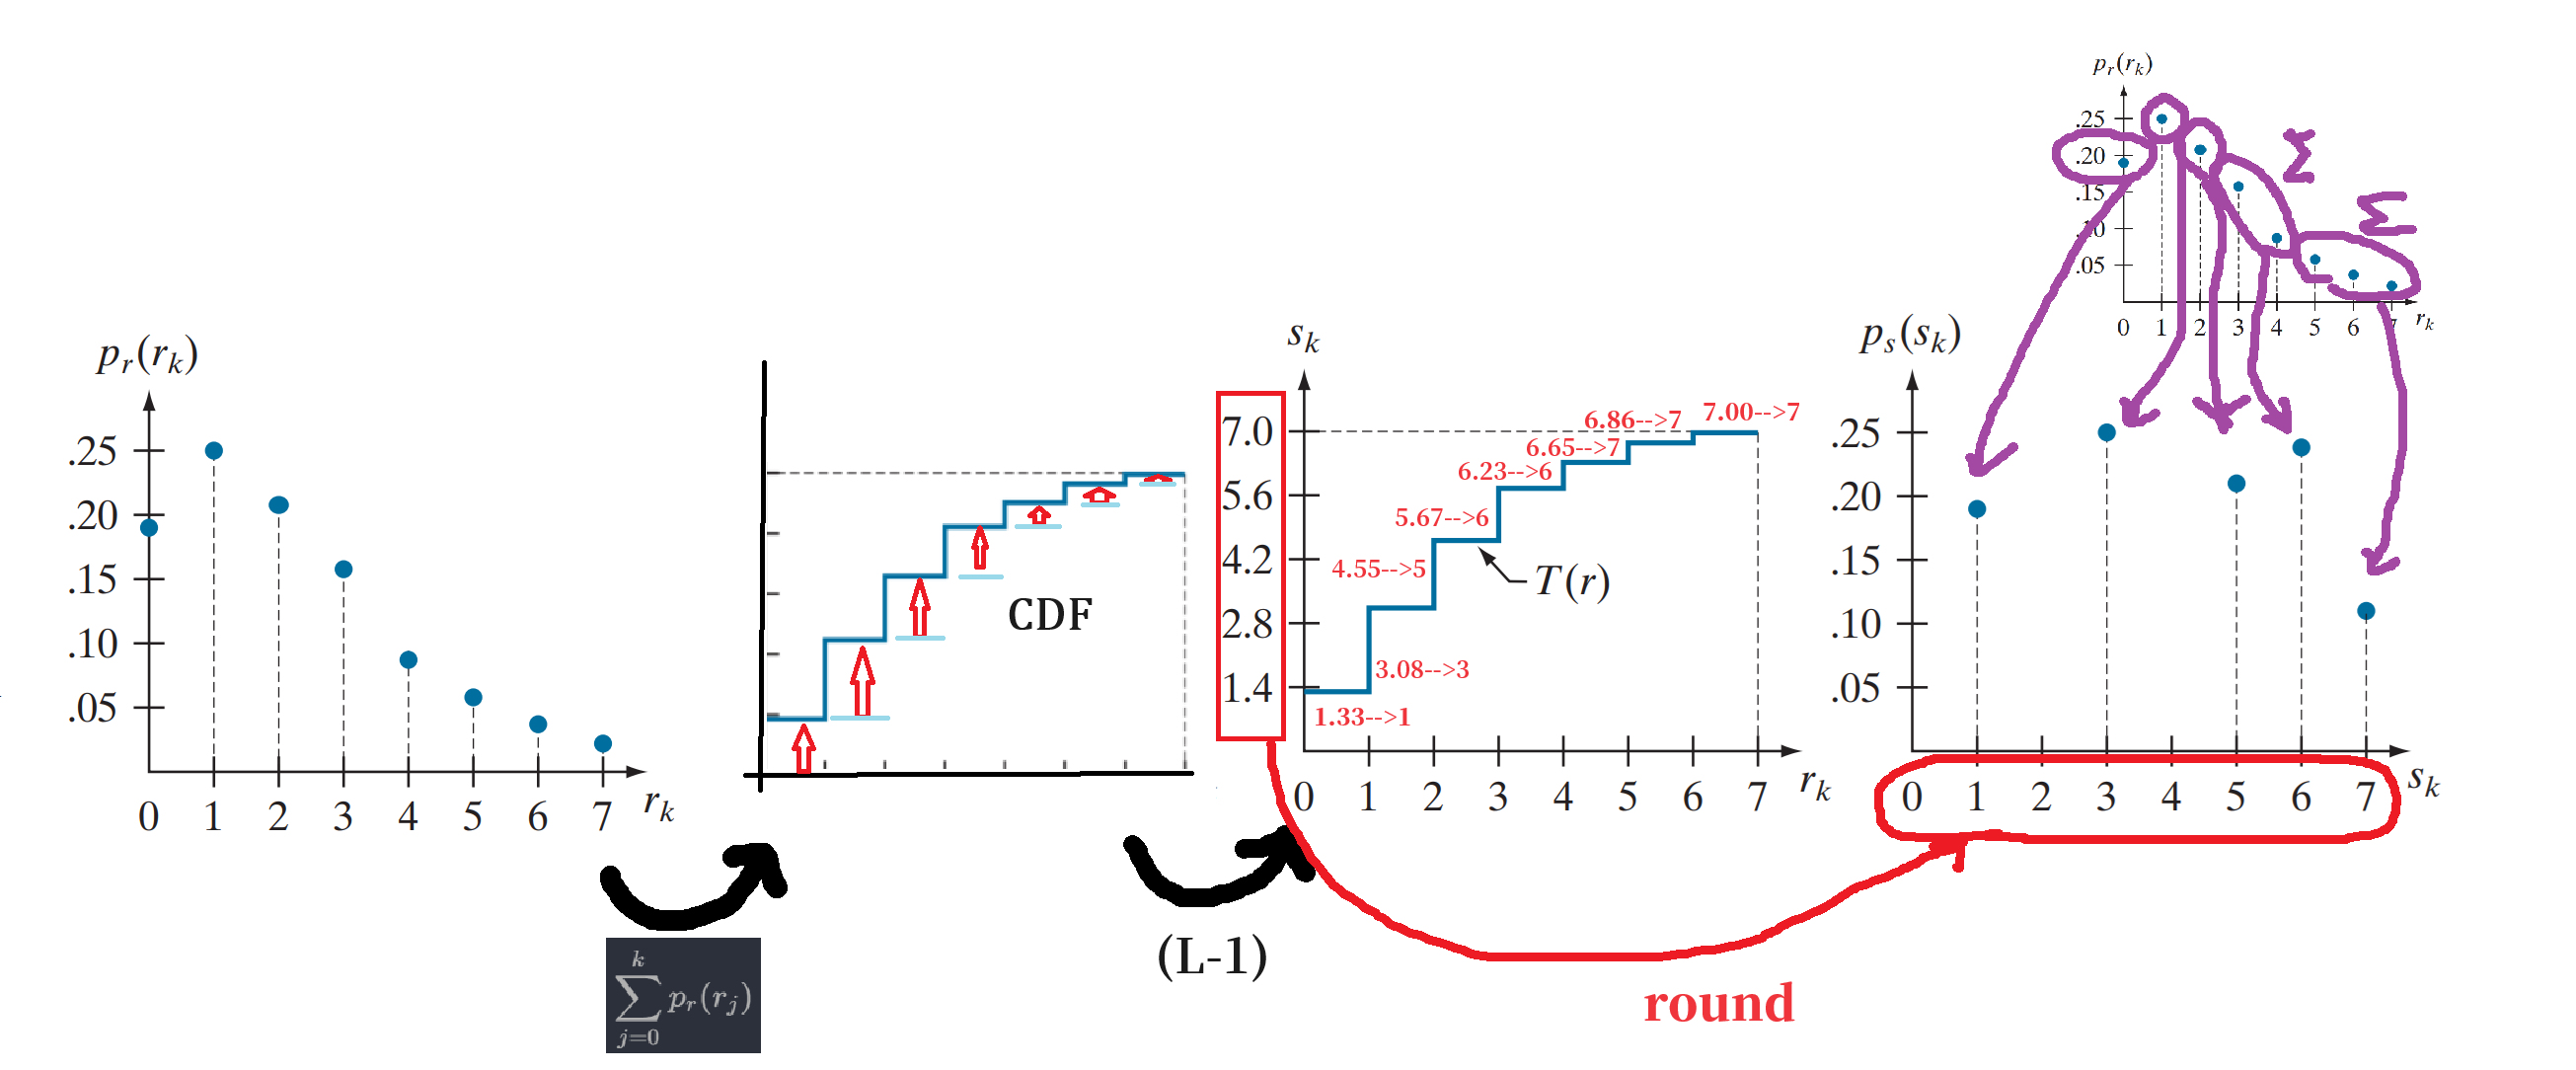


!!!若希望Eq一張彩色圖片，其實不應該分別Eq三個通道，顏色比例會炸掉。理論上Eq是針對強度進行，可以先將圖片由RGB轉為 YCbCr，然後針對Y去Eq就可以，最後再轉回來!!!詳細: https://stackoverflow.com/questions/15007304/histogram-equalization-not-working-on-color-image-opencv<br />

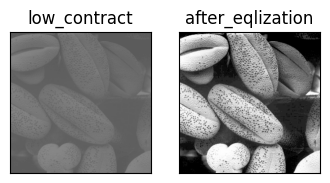

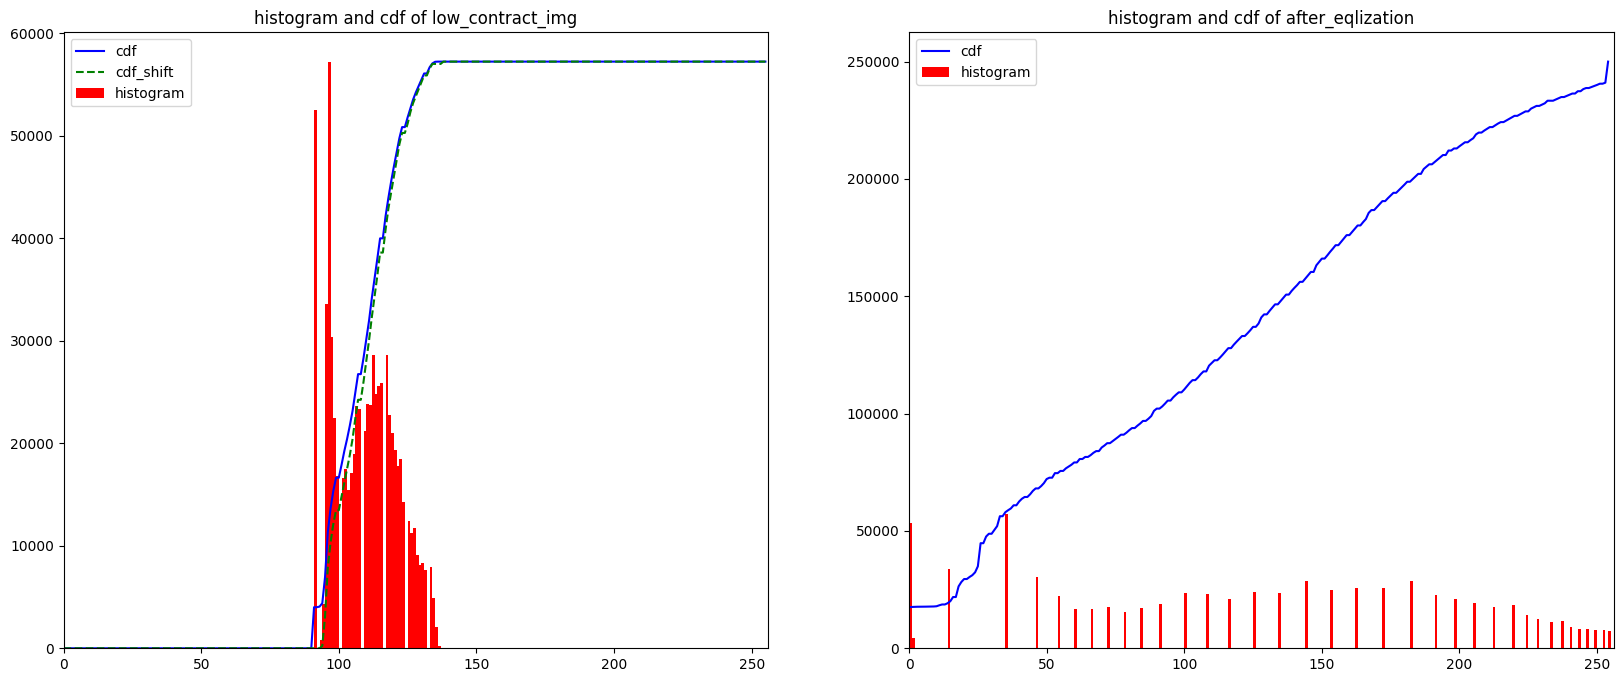

In [6]:
#source: https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img = cv2.imread('source_img/pollen_low_contract.tif')
img  =  cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#實務上不需要先變成機率
hist,bins = np.histogram(img.flatten(),256,[0,256])
cdf = hist.cumsum()##強度計數累加
cdf_normalized = cdf * float(hist.max()) / cdf.max()#用來畫圖而已!!!這是normalize到計數的超大數字(不是0~1)

###cdf_shift###
cdf_m =np.ma.masked_equal(cdf,0)#cdf裡面0的部分先蓋起來不加入運算，基本上就是不考慮前半部沒計到東西的準位。
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())#將上面的cdf(這是計數，所以超大)轉到0~255
cdf = np.ma.filled(cdf_m,0).astype('uint8')#把剛剛挖掉0的部分再放回來
cdf_normalized2 = cdf * float(hist.max()) / cdf.max()#用來畫圖而已!!!這是normalize到計數的超大數字(不是0~1)
###cdf_shift###

#之所以挖掉前半部分的0，是為了確保第一根在映射後會跑去零的位置，這裡不為零的第一根超大一根，若拿它減掉0，壓扁到255，他不會變成0.2而是17，
# ，最後肯定他不會跑去0，會跑去17，對比度就少一堆。拿掉零之後，減最小會變成減自己，第一根他一定變零。
#可以把cdf_m直接設為cdf，讓他把全部一起壓扁到255試試看，轉換後結果直接0那根不見。
#試試看   cdf_m =cff;
#試試看   print(cdf_m);print(np.ma.filled(cdf_m,0));
#看看有沒有先mask掉0的差別
#另外可以比較一下進行cdf_shift操作與否的cdf，基本上就是全部往下一格，第一突起變成0，就這樣而已。

img2 = cdf[img]####--->算出圖片
#######以下求新圖之hist
hist2,bins2 = np.histogram(img2.flatten(),256,[0,256])##
cdf2 = histogram2.cumsum()##

#########################################################
show2plt(img,img2,n1="low_contract",n2="after_eqlization")
#########################################################

fig =plt.figure(figsize=(20,8));
ax=fig.add_subplot(121)
_ =ax.plot(cdf_normalized, color = 'b')
_ =ax.plot(cdf_normalized2, color = 'g',linestyle="--")
_ =ax.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.title("histogram and cdf of low_contract_img")
plt.legend(('cdf','cdf_shift','histogram'), loc = 'upper left')

ax=fig.add_subplot(122)
_ =ax.plot(cdf2, color = 'b')
_ =ax.hist(img2.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.title("histogram and cdf of after_eqlization")
plt.legend(('cdf','histogram'), loc = 'upper left')

plt.show()

#### 直方圖匹配(histogram matching)
理想之不同連續PDF在經歷均等化之後都會變成相同的均衡pdf，其大小為1/(L-1)。我們可以利用這個特性，以直方圖等化作為橋梁，找出不同強度機率分布圖片之轉換函數。<br />
比如說，有兩張圖片，一張是希望進行修改的圖片，另一張是一張有漂亮色調的圖片，我們可以使用這個功能將圖片修改成目標圖片的色調。<br />
source: https://www.youtube.com/watch?v=r565euxWZBs。<br />
![Quick sheets - page 14.png](<attachment:Quick sheets - page 14.png>)
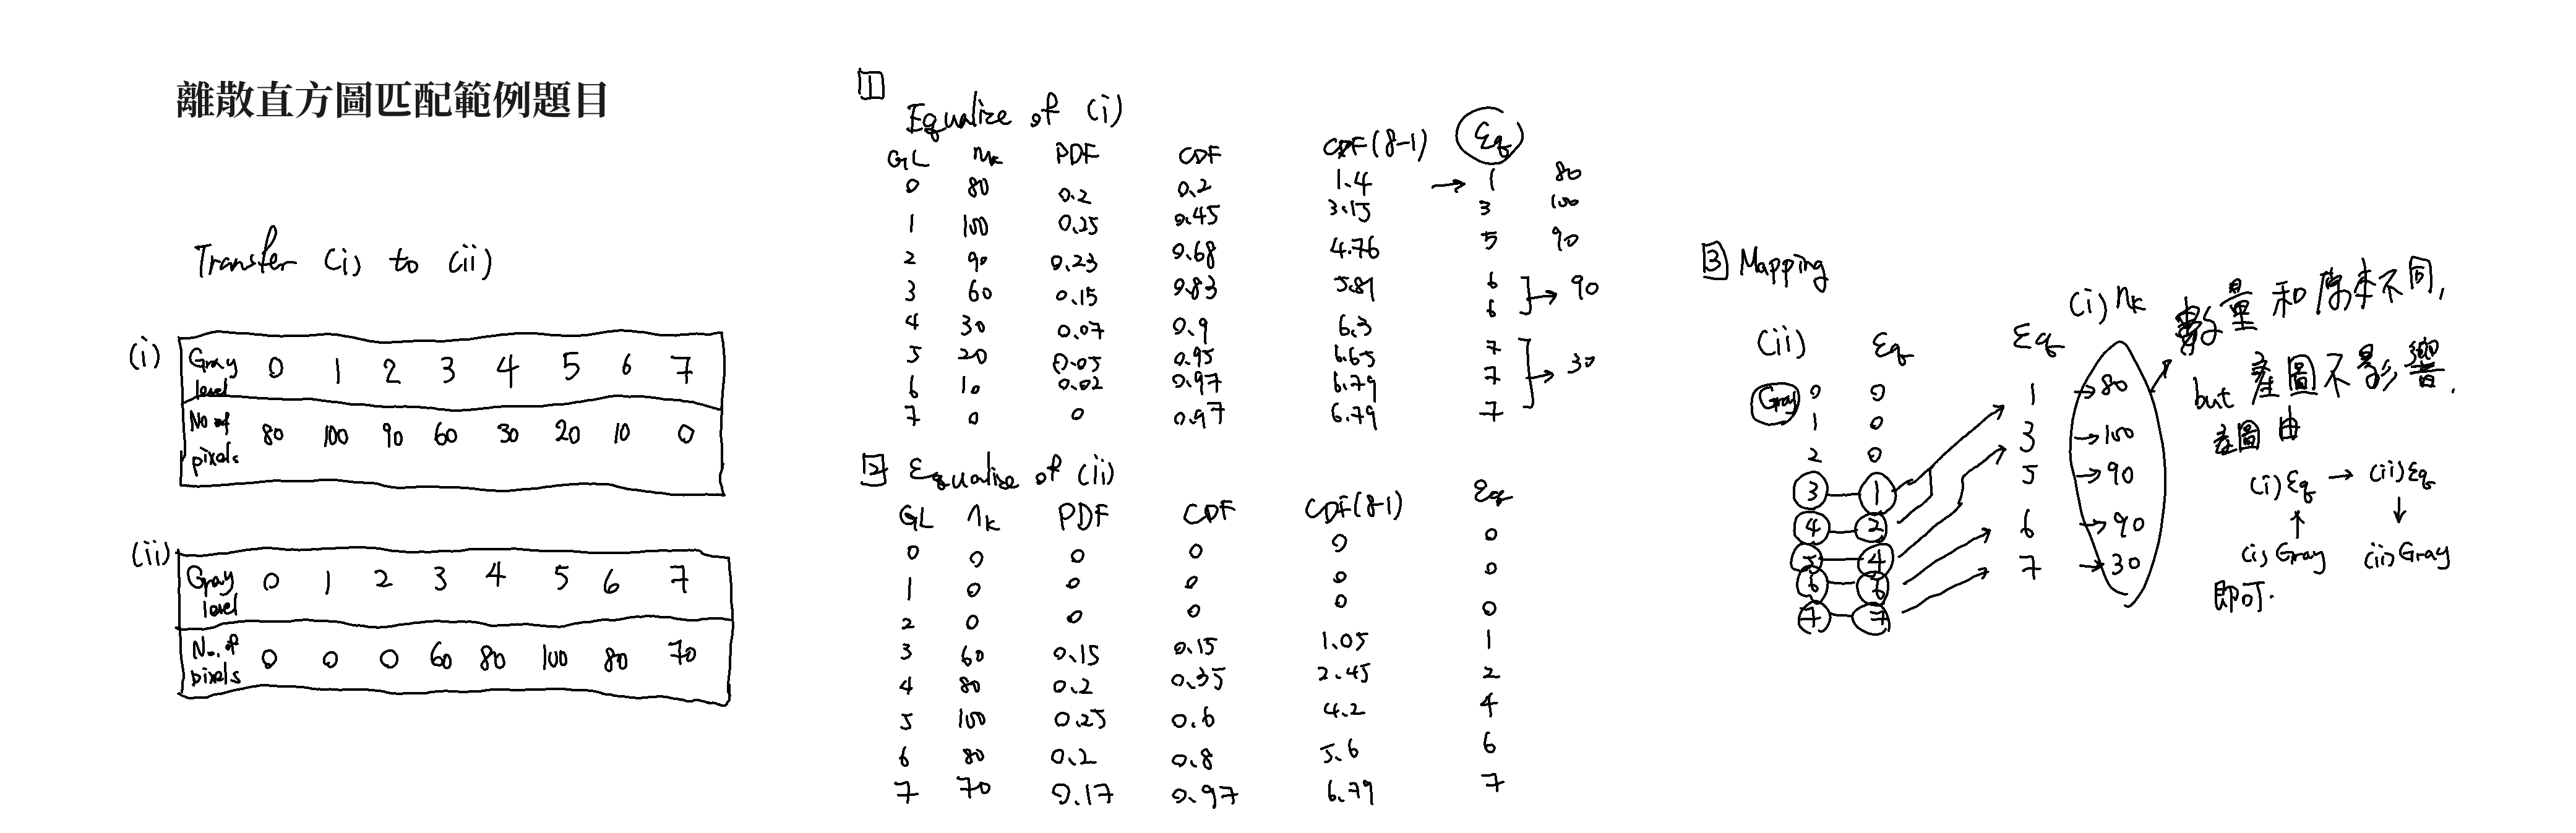

以下有兩張圖片，我們希望以夕陽圖片作為目標，將Lenna照片以夕陽的色調呈現。可以分別對RGB三個通道進行直方圖匹配，將三個通道的強度儘量以夕陽的強度分布方式呈現，即可。


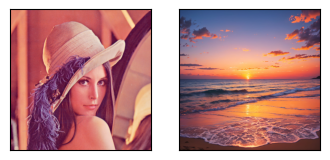

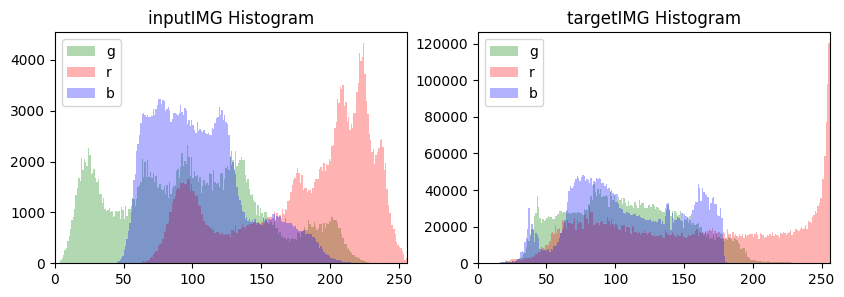

In [22]:
inputIMG = cv2.imread('source_img/Lenna.png')#######匯入兩圖片
inputIMG  =  cv2.cvtColor(inputIMG,cv2.COLOR_BGR2RGB)
targetIMG = cv2.imread('source_img/sunset.png')
targetIMG  =  cv2.cvtColor(targetIMG,cv2.COLOR_BGR2RGB)
show2plt(inputIMG,targetIMG)

#######畫histogram
red_I, green_I, blue_I = inputIMG[:,:,0], inputIMG[:,:,1], inputIMG[:,:,2]
red_T, green_T, blue_T = targetIMG[:,:,0], targetIMG[:,:,1], targetIMG[:,:,2]
fig =plt.figure(figsize=(10,3));
ax=fig.add_subplot(121)
_ =plt.hist(green_I.flatten(),256,[0,256], color = 'g',alpha=0.3,label='g')
_ =plt.hist(red_I.flatten(),256,[0,256], color = 'r',alpha=0.3,label='r')
_ =plt.hist(blue_I.flatten(),256,[0,256], color = 'b',alpha=0.3,label='b')
plt.xlim([0,256])
plt.title("inputIMG Histogram")
plt.legend(loc = 'upper left')

ax=fig.add_subplot(122)
_ =plt.hist(green_T.flatten(),256,[0,256], color = 'g',alpha=0.3,label='g')
_ =plt.hist(red_T.flatten(),256,[0,256], color = 'r',alpha=0.3,label='r')
_ =plt.hist(blue_T.flatten(),256,[0,256], color = 'b',alpha=0.3,label='b')
plt.xlim([0,256])
plt.title("targetIMG Histogram")
plt.legend( loc = 'upper left')

plt.show()

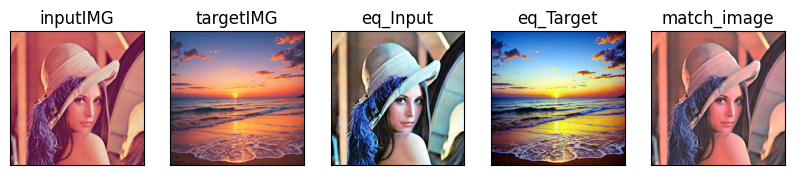

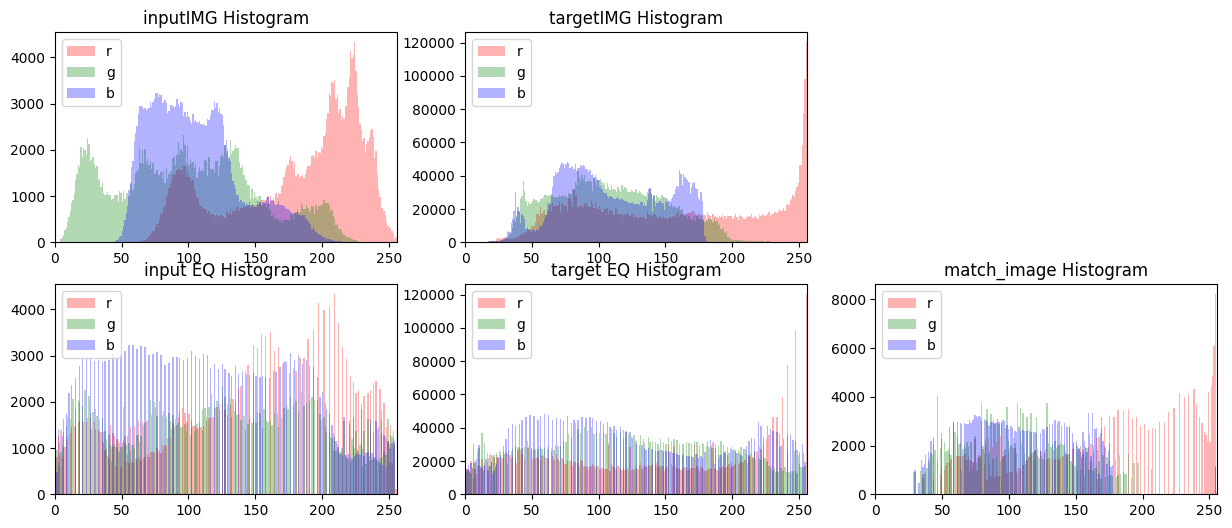

In [25]:
def cdf(im):
    hist,bins = np.histogram(im.flatten(),256,[0,256])
    cdf =hist.cumsum().astype('uint');
    cdf = cdf / float(cdf[-1])#normal  cdf最後一項是element相加
    cdf_m =cdf#np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint8')
    return cdf

def Eq(img):
    hist,bins = np.histogram(img.flatten(),256,[0,256])
    hist_normalize=hist/hist.sum();
    cdf = hist_normalize.cumsum()
    cdf_m =cdf#np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint8')
    img2 =cdf[img]
    return img2

def hist_matching(c, c_t, im):
    #c=cdf of input
    #c_t=cdf of target
    #im=input image
    pixels = np.arange(256)
    new_pixels = np.interp(c, c_t, pixels) 
    im = (np.reshape(new_pixels[im.ravel()], im.shape)).astype(np.uint8)
    return im


r_eq_I=Eq(red_I)
g_eq_I=Eq(green_I)
b_eq_I=Eq(blue_I)
eq_I = cv2.merge([r_eq_I,g_eq_I,b_eq_I])

r_eq_T=Eq(red_T)
g_eq_T=Eq(green_T)
b_eq_T=Eq(blue_T)
eq_T = cv2.merge([r_eq_T,g_eq_T,b_eq_T])

r_match=hist_matching(cdf(red_I),cdf(red_T),red_I)
g_match=hist_matching(cdf(green_I),cdf(green_T),green_I)
b_match=hist_matching(cdf(blue_I),cdf(blue_T),blue_I)
match_image= cv2.merge([r_match,g_match,b_match])

show5plt(inputIMG,targetIMG,eq_I,eq_T,match_image,n1="inputIMG",n2="targetIMG",n3="eq_Input",n4="eq_Target",n5="match_image")


fig =plt.figure(figsize=(15,6));
ax=fig.add_subplot(231)
_ =plt.hist(red_I.flatten(),256,[0,256], color = 'r',alpha=0.3,label='r')
_ =plt.hist(green_I.flatten(),256,[0,256], color = 'g',alpha=0.3,label='g')
_ =plt.hist(blue_I.flatten(),256,[0,256], color = 'b',alpha=0.3,label='b')
plt.xlim([0,256])
plt.title("inputIMG Histogram")
plt.legend(loc = 'upper left')

ax=fig.add_subplot(232)
_ =plt.hist(red_T.flatten(),256,[0,256], color = 'r',alpha=0.3,label='r')
_ =plt.hist(green_T.flatten(),256,[0,256], color = 'g',alpha=0.3,label='g')
_ =plt.hist(blue_T.flatten(),256,[0,256], color = 'b',alpha=0.3,label='b')
plt.xlim([0,256])
plt.title("targetIMG Histogram")
plt.legend( loc = 'upper left')

ax=fig.add_subplot(234)
_ =plt.hist(r_eq_I.flatten(),256,[0,256], color = 'r',alpha=0.3,label='r')
_ =plt.hist(g_eq_I.flatten(),256,[0,256], color = 'g',alpha=0.3,label='g')
_ =plt.hist(b_eq_I.flatten(),256,[0,256], color = 'b',alpha=0.3,label='b')
plt.xlim([0,256])
plt.title("input EQ Histogram")
plt.legend(loc = 'upper left')

ax=fig.add_subplot(235)
_ =plt.hist(r_eq_T.flatten(),256,[0,256], color = 'r',alpha=0.3,label='r')
_ =plt.hist(g_eq_T.flatten(),256,[0,256], color = 'g',alpha=0.3,label='g')
_ =plt.hist(b_eq_T.flatten(),256,[0,256], color = 'b',alpha=0.3,label='b')
plt.xlim([0,256])
plt.title("target EQ Histogram")
plt.legend( loc = 'upper left')

ax=fig.add_subplot(236)
_ =plt.hist(r_match.flatten(),256,[0,256], color = 'r',alpha=0.3,label='r')
_ =plt.hist(g_match.flatten(),256,[0,256], color = 'g',alpha=0.3,label='g')
_ =plt.hist(b_match.flatten(),256,[0,256], color = 'b',alpha=0.3,label='b')
plt.xlim([0,256])
plt.title("match_image Histogram")
plt.legend( loc = 'upper left')
plt.show()
